# Python Flight Mechanics Engine 

In [1]:
from pyfme.aircrafts import LinearB747, SimplifiedCessna172
from pyfme.models import EulerFlatEarth
import numpy as np
nl = np.linalg
import matplotlib.pyplot as plt
from pyfme.environment.atmosphere import ISA1976
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment import Environment
from pyfme.utils.trimmer import steady_state_trim
from pyfme.models.state.position import EarthPosition
from pyfme.simulator import Simulation
from pyfme.models import EulerFlatEarth

In [2]:
%load_ext autoreload
%autoreload 2

# Test on Boeing

In [3]:
aircraft = LinearB747()

In [4]:
print(f"Aircraft mass: {aircraft.mass} kg")
print(f"Aircraft inertia tensor: \n {aircraft.inertia} kg/m²")

Aircraft mass: 288660.5504587156 kg
Aircraft inertia tensor: 
 [[ 24700000.         0.  -2120000.]
 [        0.  44900000.         0.]
 [ -2120000.         0.  67300000.]] kg/m²


In [5]:
state, environment = aircraft.trimmed_conditions()

In [6]:
system = EulerFlatEarth(t0=0, full_state=state)

In [7]:
A_long, A_lat = system.linearized_model(state, aircraft, environment, None)

In [8]:
print(f"{A_long}")

[[ -6.86619629e-03   1.39437135e-02   0.00000000e+00  -9.80665000e+00]
 [ -9.04964592e-02  -3.14906754e-01   2.35892792e+02  -0.00000000e+00]
 [  3.89092422e-04  -3.36169904e-03  -4.28171388e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]]


In [9]:
d = aircraft.calculate_derivatives(None, None, None)

In [10]:
val, vec = nl.eig(A_long)

In [11]:
val

array([-0.37168337+0.88692454j, -0.37168337-0.88692454j,
       -0.00328880+0.0671904j , -0.00328880-0.0671904j ])

In [12]:
print(f"{A_lat}")

[[ -5.57748538e-02   0.00000000e+00  -2.35900000e+02   9.80665000e+00]
 [ -1.27028796e-02  -4.35107741e-01   4.14335937e-01   0.00000000e+00]
 [  3.56656916e-03  -6.05604146e-03  -1.45800775e-01   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00]]


In [13]:
val, vec = nl.eig(A_lat)

In [14]:
val

array([-0.03309986+0.94696989j, -0.03309986-0.94696989j,
       -0.56322438+0.j        , -0.00725928+0.j        ])

Eigen values are the same as the ones in Etkin. So the matrix was copy-pasted right in EulerFlatEarth.linearize()

# Simplified Cessna: compare response with eigenvalue analysis

In [48]:
aircraft = SimplifiedCessna172()

In [49]:
atmosphere = ISA1976()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

In [50]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}
trimmed_state, trimmed_controls = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)
environment.update(trimmed_state)

In [51]:
system = EulerFlatEarth(t0=0, full_state=trimmed_state)

In [52]:
aircraft.calculate_derivatives(trimmed_state, environment=environment, controls=trimmed_controls)

{'Lp': -7133.3285464529754,
 'Lq': -1.3596490723877686e-10,
 'Lr': 2845.5233747989769,
 'Lu': -1.5072258133617629e-13,
 'Lv': -93.803403491879237,
 'Lw': 6.4642542808689936e-11,
 'Lw_dot': 0.0,
 'Mp': -1.3635270481322531e-10,
 'Mq': -5632.7295473571794,
 'Mr': 2.5855995439045339e-10,
 'Mu': -2.0740884413894751e-10,
 'Mv': -8.5234948148304966e-12,
 'Mw': -707.13949139550539,
 'Mw_dot': 0.0,
 'Np': -283.31950651664334,
 'Nq': -2.0902086546512417e-11,
 'Nr': -895.8625397666973,
 'Nu': -1.600102250108547e-12,
 'Nv': 63.401932933487544,
 'Nw': 4.8437512785752048e-12,
 'Nw_dot': 0.0,
 'Xp': 8.5635844119039128e-12,
 'Xq': -107.98409108583664,
 'Xr': -4.3879010396940393e-11,
 'Xu': -81.920634161805893,
 'Xv': -1.0186591357214635e-10,
 'Xw': 117.92566393495383,
 'Xw_dot': 0.0,
 'Yp': -94.244627388807359,
 'Yq': -8.5635868519158715e-12,
 'Yr': 482.90054315893269,
 'Yu': -7.5184642244713184e-12,
 'Yv': -126.09881477888285,
 'Yw': 2.053118461568279e-11,
 'Yw_dot': 0.0,
 'Zp': 0.0,
 'Zq': -2203.439

In [53]:
A_long, A_lat = system.linearized_model(trimmed_state, aircraft, environment, trimmed_controls)

In [54]:
long_val, long_vec=nl.eig(A_long)
long_val = np.expand_dims(long_val, axis = 0)
print(f"longitudinal eigenvalues : {long_val}")

longitudinal eigenvalues : [[-2.61286215+4.04181191j -2.61286215-4.04181191j -0.03450179+0.26321042j
  -0.03450179-0.26321042j]]


In [55]:
print(f"{A_lat}")

[[ -1.20869794e-01  -9.03365248e-02  -4.43934827e+01   9.80665000e+00]
 [ -7.29808437e-02  -5.54986617e+00   2.21387166e+00   0.00000000e+00]
 [  2.37736990e-02  -1.06235762e-01  -3.35919827e-01   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00]]


In [56]:
lat_val, lat_vec=nl.eig(A_lat)
lat_val = np.expand_dims(lat_val, axis = 0)
print(f"lat eigenvalues : {lat_val}")

lat eigenvalues : [[-5.54552962+0.j         -0.24937803+1.12210093j -0.24937803-1.12210093j
   0.03762989+0.j        ]]


## Longitudinal checks

In [57]:
trimmed_state

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: 0.080 rad, phi: 0.000 rad, psi: 0.500 rad 
u: 44.86 m/s, v: -0.00 m/s, w: 3.59 m/s 
P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
u_dot: -0.00 m/s², v_dot: -0.00 m/s², w_dot: -0.00 m/s² 
P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: -0.00 rad/s² 

In [58]:
def linear_stab_2_body(long_state=np.zeros(4), lat_state=np.zeros(4), u0=0, theta0=0,alpha0=0, beta0=0):
    # velocities
    v = wind2body(np.array([long_state[0] + u0, lat_state[0], long_state[1]]), alpha=alpha0, beta=beta0)
    # Roll rates
    r = wind2body(np.array([lat_state[1], long_state[2], lat_state[2]]), alpha=alpha0, beta=beta0)
    long_stateB = np.copy(long_state)
    lat_stateB = np.copy(lat_state)
    long_stateB[0] = v[0]
    long_stateB[1] = v[2]
    long_stateB[2] = r[1]
    long_stateB[3] += theta0
    lat_stateB[0] = v[1]
    lat_stateB[1] = r[0]
    lat_stateB[2] = r[2]
    return long_stateB.real, lat_stateB.real

In [59]:
from pyfme.utils.coordinates import wind2body, body2wind, stab2body

In [60]:
alpha = np.arctan2(trimmed_state.velocity.w, trimmed_state.velocity.u)
u = trimmed_state.velocity.u*1.0

In [61]:
perturbation = (long_vec.T[0] + long_vec.T[1])/10

### Eigenvalue approach

In [62]:
C = nl.lstsq(a=long_vec,b=perturbation.real)[0].real

In [63]:
# stability axis
u, v, w = body2wind(trimmed_state.velocity.vel_body, alpha, 0)
theta0 = trimmed_state.attitude.theta*1.0

In [64]:
trimmed_state.velocity._vel_body

array([  4.48563585e+01,  -4.08894829e-12,   3.59264617e+00])

In [65]:
wind2body(np.array([u,v,w]), alpha=alpha, beta=0)

array([  4.48563585e+01,  -4.08894829e-12,   3.59264617e+00])

In [66]:
t = np.linspace(0,3,100)
N = len(t)
X = np.zeros((N,4))
xx = []
for i in range(N):
    x_stab = (long_vec*np.exp(long_val*t[i])).dot(C)
    xx.append(x_stab[1])
    X[i,:] = linear_stab_2_body(long_state=x_stab.real, alpha0=alpha, u0=u, theta0 = theta0)[0]

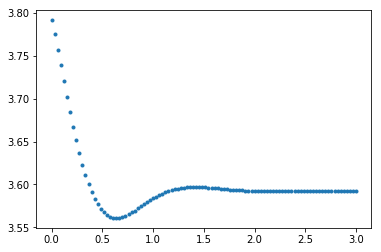

In [67]:
plt.plot(t,X[:,1],'.')
plt.show()

### Simulation

In [68]:
from pyfme.utils.input_generator import Constant

In [69]:
controls = {
    'delta_elevator': Constant(trimmed_controls['delta_elevator']),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [78]:
# Perturbate
trimmed_state.cancel_perturbation()
p = linear_stab_2_body(long_state=perturbation.real, alpha0=alpha)[0]
trimmed_state.perturbate(np.array([p[0],0,p[1]]), 'velocity')
trimmed_state.perturbate(np.array([0,p[2],0]), 'angular_vel')
trimmed_state.perturbate(np.array([0,p[3],0]), 'attitude')

In [79]:
trimmed_state

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: 0.080 rad, phi: 0.004 rad, psi: 0.500 rad 
u: 44.84 m/s, v: -0.00 m/s, w: 3.79 m/s 
P: 0.00 rad/s, Q: -0.00 rad/s, R: 0.00 rad/s 
u_dot: -0.00 m/s², v_dot: -0.00 m/s², w_dot: -0.00 m/s² 
P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: -0.00 rad/s² 

In [71]:
perturbation

array([ 0.00438011+0.j,  0.19901295+0.j, -0.00220572+0.j,  0.00353290+0.j])

In [72]:
environment.update(trimmed_state)
system = EulerFlatEarth(t0=0, full_state=trimmed_state)

In [73]:
sim = Simulation(aircraft, system, environment, controls)

In [74]:
r = sim.propagate(10)

time: 100%|████████████████████████████████████████████████████████████▉| 9.999999999999831/10 [00:06<00:00,  1.49it/s]


In [75]:
trimmed_state.cancel_perturbation()

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: 0.080 rad, phi: 0.000 rad, psi: 0.500 rad 
u: 44.86 m/s, v: -0.00 m/s, w: 3.59 m/s 
P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
u_dot: -0.00 m/s², v_dot: -0.00 m/s², w_dot: -0.00 m/s² 
P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: -0.00 rad/s² 

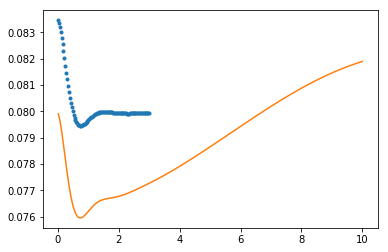

In [76]:
plt.plot(t,X[:,3],'.')
plt.plot(r.theta)
plt.show()

In [77]:
trimmed_state

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: 0.080 rad, phi: 0.000 rad, psi: 0.500 rad 
u: 44.86 m/s, v: -0.00 m/s, w: 3.59 m/s 
P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
u_dot: -0.00 m/s², v_dot: -0.00 m/s², w_dot: -0.00 m/s² 
P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: -0.00 rad/s² 